Περιλαμβάνουμε αρχικά την συνάρτηση interest_points_visualization για την οπτικοποίηση των γωνιών που ανιχνεύονται.

In [16]:
def fspecial_log(p2, std):
    siz = int((p2-1)/2)
    x = y = np.linspace(-siz, siz, 2*siz+1)
    x, y = np.meshgrid(x, y)
    arg = -(x**2 + y**2) / (2*std**2)
    h = np.exp(arg)
    h1 = h*(x**2 + y**2 - 2*std**2) / (std**4)
    return h1

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def interest_points_visualization(I_, kp_data_, ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=2)
        ax.add_patch(circ)

    return ax

def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

Επισυνάπτουμε τις 5 μεθόδους που αναλύθηκαν στο δεύτερο μέρος της εργασίας σε μορφή συναρτήσεων. Κάθε μία από αυτές τις συναρτήσεις θα επιστρέφει τον Νx3 πίνακα που με τις ανιχνευθείσες γωνίες που θα μας χρειαστεί για το 3ο μέρος.

## 1η μέθοδος Harris-Stephens

In [2]:
N = 4
sigma = 2
r = 2.5
k = 0.05
u_corn = 0.005
s = 1.5

In [11]:
def HarrisStephens(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005):
    n = int(np.ceil(3*sigma))*2 + 1
    Gs = cv2.getGaussianKernel(n, sigma)
    Gr = cv2.getGaussianKernel(n, r)
    Is = cv2.filter2D(img,-1,Gs)
    dIs = np.gradient(Is)
    J1 = cv2.filter2D(np.multiply(dIs[0], dIs[0]),-1,Gr)
    J2 = cv2.filter2D(np.multiply(dIs[0], dIs[1]),-1,Gr)
    J3 = cv2.filter2D(np.multiply(dIs[1], dIs[1]),-1,Gr)
    D = np.sqrt(np.square(J1-J3)+4*np.square(J2))
    l_plus = (J1 + J3 + D) / 2
    l_minus = (J1 + J3 - D) / 2
    R = np.multiply(l_plus, l_minus) - k*np.square(l_minus + l_plus)
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = ( R==cv2.dilate(R,B_sq) )
    R_max = np.max(R)
    Cond2 = np.where(R>u_corn*R_max, 1, 0)
    Cond = Cond1&Cond2
    points=np.sum(Cond==True)
    scale = np.zeros(points)
    scale.fill(sigma)
    num_of_points=scale.shape[0]
    N2 = np.zeros((num_of_points, 2))
    a = np.where(Cond==1)
    for j in range(len(a[0])):
        N2[j,1]=a[0][j]
        N2[j,0]=a[1][j]
    scale = np.expand_dims(scale, axis=1)
    return np.concatenate((N2, scale), axis=1)

In [12]:
import cv2

sun = cv2.imread('sunflowers.png', cv2.IMREAD_GRAYSCALE)

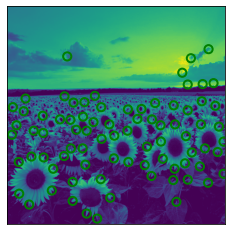

In [19]:
inp = HarrisStephens(sun, sigma=3)
interest_points_visualization(sun, inp)

## 2η μέθοδος Harris Laplacian

In [25]:
def HarrisLaplacian(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005, N=4, s=1.5):
    sigmas = [sigma*(s**i) for i in range(N)]
    
    ind = {k: v for v, k in enumerate(sigmas)}
    
    rs = [r*(s**i) for i in range(N)]
    Angles = [HarrisStephens(img, sigmas[i], rs[i]) for i in range(N)]
    LoGs = [np.abs(fspecial_log(int(np.ceil(3*x))*2 + 1,x))*(x**2) for x in sigmas]
    Ls = [cv2.filter2D(img,-1,LoGs[i]) for i in range(N)]
    total = np.zeros((0,3))
    indices=np.zeros((0))
    total = np.vstack(Angles)
    deletion=[]
    count=0
    for a in total:
        x, y, si = a
        x = int(x)
        y = int(y)
        pos=ind[si]
        if pos==0:
            if Ls[pos+1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        elif pos==N-1:
            if Ls[pos-1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        else:
            if Ls[pos+1][y,x]>=Ls[pos][y,x] and Ls[pos-1][y,x]>=Ls[pos][y,x]:
                deletion.append(count)
        count+=1
    return np.delete(total, deletion, 0)

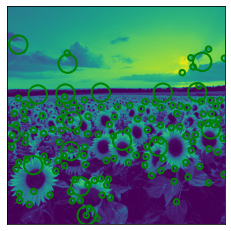

In [29]:
inp=HarrisLaplacian(sun, N=4)
interest_points_visualization(sun, inp)

## 3η μέθοδος Βlobs

In [33]:
def Blobs(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005):
    n = int(np.ceil(3*sigma))*2 + 1
    Gs = cv2.getGaussianKernel(n, sigma)
    Gr = cv2.getGaussianKernel(n, r)
    Is = cv2.filter2D(img,-1,Gs)
    Lx, Ly = np.gradient(Is)
    Lxx, Lxy = np.gradient(Lx)
    Lyx, Lyy = np.gradient(Ly)
    CriterionR = np.multiply(Lxx, Lyy) - np.multiply(Lxy, Lyx)
    ns = np.ceil(3*sigma)*2+1
    B_sq = disk_strel(ns)
    Cond1 = ( CriterionR==cv2.dilate(CriterionR,B_sq) )
    R_max = np.max(CriterionR)
    Cond2 = np.where(CriterionR>u_corn*R_max, 1, 0)
    Cond = Cond1&Cond2
    points = np.sum(Cond==True)
    scale = np.zeros(points)
    scale.fill(sigma)
    num_of_points=scale.shape[0]
    N2 = np.zeros((num_of_points, 2))
    a = np.where(Cond==1)
    for j in range(len(a[0])):
        N2[j,1]=a[0][j]
        N2[j,0]=a[1][j]
    scale = np.expand_dims(scale, axis=1)
    return np.concatenate((N2, scale), axis=1)

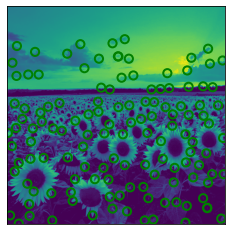

In [34]:
inp = Blobs(sun, sigma=3)
interest_points_visualization(sun, inp)

## 4η μέθοδος Multiscale Blobs

In [36]:
def MultiscaleBlobs(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005, N=4, s=1.5):
    sigmas = [sigma*(s**i) for i in range(N)]
    
    ind = {k: v for v, k in enumerate(sigmas)}
    
    rs = [r*(s**i) for i in range(N)]
    Angles = [Blobs(img, sigmas[i], rs[i]) for i in range(N)]
    LoGs = [np.abs(fspecial_log(int(np.ceil(3*x))*2 + 1,x))*(x**2) for x in sigmas]
    Ls = [cv2.filter2D(img,-1,LoGs[i]) for i in range(N)]
    total = np.zeros((0,3))
    indices=np.zeros((0))
    total = np.vstack(Angles)
    deletion=[]
    count=0
    for a in total:
        x, y, si = a
        x = int(x)
        y = int(y)
        pos=ind[si]
        if pos==0:
            if Ls[pos+1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        elif pos==N-1:
            if Ls[pos-1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        else:
            if Ls[pos+1][y,x]>=Ls[pos][y,x] and Ls[pos-1][y,x]>=Ls[pos][y,x]:
                deletion.append(count)
        count+=1
    return np.delete(total, deletion, 0)

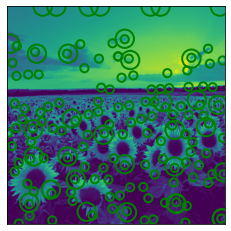

In [39]:
inp = MultiscaleBlobs(sun, sigma=3, N=3)
interest_points_visualization(sun, inp)

## 5η μέθοδος Box Filters

In [46]:
def BoxFilters(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005):
    n = int(np.ceil(3*sigma)*2+1)
    
    Dxx = np.zeros((n,n))
    Dxy = np.zeros((n,n))

    q = int(np.floor(n/6))
    small=int(2*np.floor(n/6)+1)
    big=int(4*np.floor(n/6)+1)

    Dxx[((n//2+1)-q):((n//2+1)+q), :small]=1
    Dxx[((n//2+1)-q):((n//2+1)+q), small+1:2*small+1]=-2
    Dxx[((n//2+1)-q):((n//2+1)+q), 2*small+1:3*small+1]=1

    Dyy = np.transpose(Dxx)

    middle=n//2+1
    Dxy[middle-1-small:middle-1,middle-1-small:middle-1]=1
    Dxy[middle:middle+small,middle:middle+small]=1
    Dxy[middle-1-small:middle-1,middle:middle+small]=-1
    Dxy[middle:middle+small,middle-1-small:middle-1]=-1

    Lxx = cv2.filter2D(img ,-1, Dxx)
    Lxy = cv2.filter2D(img ,-1, Dxy)
    Lyy = cv2.filter2D(img ,-1, Dyy)

    CriterionR = np.multiply(Lxx, Lyy) - 0.81*np.multiply(Lxy, Lxy)
    
    B_sq = disk_strel(n)
    C1 = ( CriterionR==cv2.dilate(CriterionR,B_sq) )

    R_max = np.max(CriterionR)
    C2 = np.where(CriterionR>u_corn*R_max, 1, 0)

    Cond = C1&C2
    points = np.sum(Cond==True)
    scale = np.zeros(points)
    scale.fill(sigma)
    num_of_points=scale.shape[0]
    N2 = np.zeros((num_of_points, 2))
    a = np.where(Cond==1)
    for j in range(len(a[0])):
        N2[j,1]=a[0][j]
        N2[j,0]=a[1][j]
    scale = np.expand_dims(scale, axis=1)
    return np.concatenate((N2, scale), axis=1)

def MultiBoxFilters(img, sigma=2, r = 2.5, k=0.05, u_corn = 0.005, N=4, s=1.5):
    
    sigmas = [sigma*(s**i) for i in range(N)]
    ind = {k: v for v, k in enumerate(sigmas)}
    rs = [r*(s**i) for i in range(N)]
    Angles = [BoxFilters(img, sigmas[i], rs[i]) for i in range(len(sigmas))]
    LoGs = [np.abs(fspecial_log(int(np.ceil(3*x))*2 + 1,x))*(x**2) for x in sigmas]
    Ls = [cv2.filter2D(img,-1,LoGs[i]) for i in range(N)]
    total = np.zeros((0,3))
    indices=np.zeros((0))
    total = np.vstack(Angles)
    deletion=[]
    count=0
    for a in total:
        x, y, si = a
        x = int(x)
        y = int(y)
        pos=ind[si]
        if pos==0:
            if Ls[pos+1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        elif pos==N-1:
            if Ls[pos-1][y,x]>Ls[pos][y,x]:
                deletion.append(count)
        else:
            if Ls[pos+1][y,x]>=Ls[pos][y,x] and Ls[pos-1][y,x]>=Ls[pos][y,x]:
                deletion.append(count)
        count+=1
    return np.delete(total, deletion, 0)

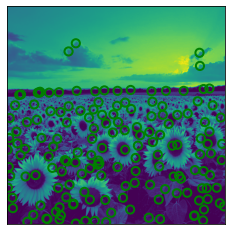

In [47]:
inp = BoxFilters(sun, sigma=3)
interest_points_visualization(sun, inp)

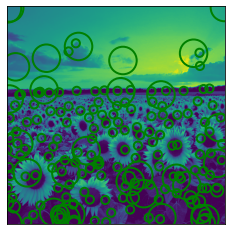

In [48]:
inp = MultiBoxFilters(sun, sigma=3, N=4)
interest_points_visualization(sun, inp)

# 3o Μέρος

## 3.1. Ταίριασμα Εικόνων υπό Περιστροφή και Αλλαγή Κλίμακας

In [54]:
import cv20_lab1_part3_utils

In [56]:
import cv20_lab1_part3_utils as p3
import cv20_lab1_part2_utils as p2

if __name__ == '__main__':
    # Here is a lambda which acts as a wrapper for detector function, e.g. harrisDetector.
    # The detector arguments are, in order: image, sigma, rho, k, threshold.
    detect_fun = lambda I: p2.harrisDetector(I, 2, 2.5, 0.05, 0.005)

    # You can use either of the following lines to extract features (HOG/SURF).
    desc_fun = lambda I, kp: p3.featuresSURF(I,kp)
    # desc_fun = lambda I, kp: p3.featuresHOG(I,kp)

    # Execute evaluation by providing the above functions as arguments
    # Returns 2 1x3 arrays containing the errors
    avg_scale_errors, avg_theta_errors = p3.matching_evaluation(detect_fun, desc_fun)
    print('Avg. Scale Error for Image 1: {:.3f}'.format(avg_scale_errors[0]))
    print('Avg. Theta Error for Image 1: {:.3f}'.format(avg_theta_errors[0]))

FileNotFoundError: [Errno 2] No such file or directory: './snrImgSet.mat'